### Import Library ###

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras import Model
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import math
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

## 10.1 Load Base Model and Add New Layers ##

In [2]:
# Load base model
base_model = MobileNet(weights="imagenet", include_top=False)

In [3]:
# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x) # we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(1024, activation="relu")(x) # dense layer 2
x = Dense(512, activation="relu")(x)
preds = Dense(3, activation="softmax")(x)

In [4]:
# Assign transfer base model + new layers to model
model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, None, None, 512)  4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_pw_9 (Conv2D)          (None, None, None, 512)   262144    
                                                                 
 conv_pw_9

In [5]:
# Assign Trainable layers and freeze layer 
for layer in model.layers[:20]:
  layer.trainable = False
for layer in model.layers[20:]:
  layer.trainable = True


## 10.2 Model Training and Validation ##

### 10.2.1 Create ImageDataGenerator ( Train, Validation ) ###

In [6]:
# Create DataGenerator Object
datagen = ImageDataGenerator( rescale=1./255, rotation_range=30, zoom_range=0.5, width_shift_range=0.2, height_shift_range=0.2,shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [7]:
seed_val = 0

In [8]:
# Create Train Image generator
train_generator = datagen.flow_from_directory("./assets/Cat_Dog_Horse/train", target_size=(224,224), color_mode='rgb', batch_size=16, class_mode="categorical", seed=seed_val, shuffle=True)

Found 175 images belonging to 3 classes.


In [9]:
# Create Validation Image generator
val_generator = datagen.flow_from_directory("./assets/Cat_Dog_Horse/validate", target_size=(224,224), batch_size=16, class_mode="categorical", seed=seed_val, shuffle=True)

Found 31 images belonging to 3 classes.


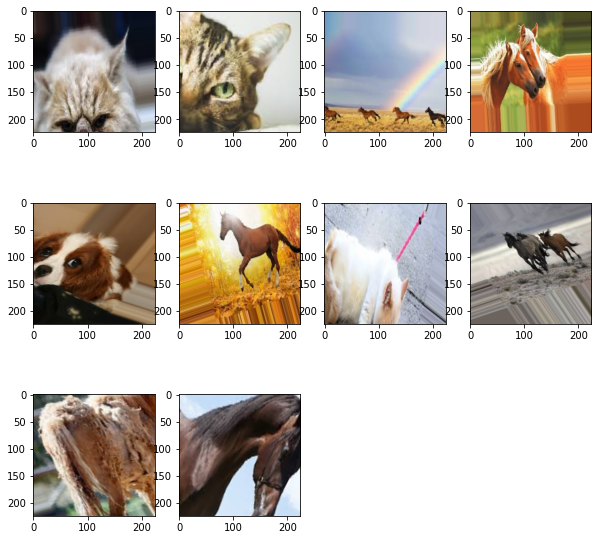

In [10]:
# View Training Images and Validation Images
# train_generator.n --> number of image in train_generator
Npic = 10
plt.figure(figsize=(10,10))
for i in range(Npic):

  plt.subplot(math.ceil(Npic / 4), 4, i + 1)
  batch = train_generator.next()
  img_train = (batch[0]*255).astype("uint8")
  plt.imshow(img_train[0])
  

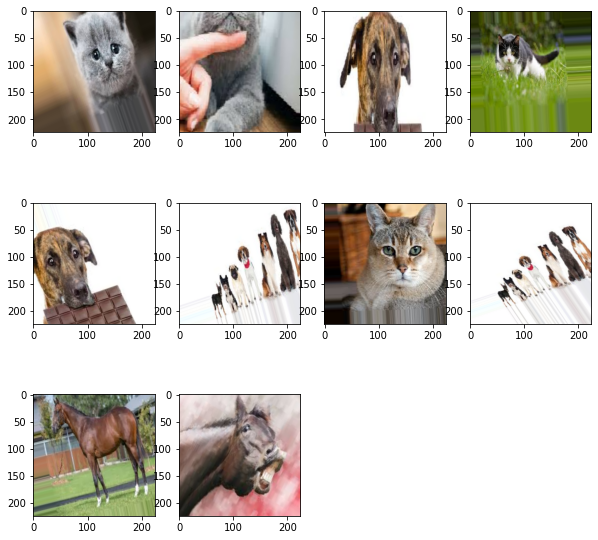

In [11]:
# View Training Images and Validation Images
Npic = 10
plt.figure(figsize=(10, 10))
for i in range(Npic):

  plt.subplot(math.ceil(Npic / 4), 4, i + 1)
  batch = val_generator.next()
  img_val = (batch[0]*255).astype("uint8")
  plt.imshow(img_val[0])


### 10.2.2 Create Optimizer, parameters ###

In [12]:
# Create Optimizer
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
train_generator.n

175

In [14]:
# Define training Generator Parameter
epochs = 32
step_size_train = train_generator.n // train_generator.batch_size
step_size_val = val_generator.n // val_generator.batch_size
# check step_size_train = step_size_val -> if not adjust batch_size to make it equal

### 10.2.3 Training, Validation, plot accuracy, loss

In [15]:
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
validation_data=val_generator, validation_steps=step_size_val, epochs=epochs, verbose=1)

/var/folders/rq/qhkf31pj62z2ycvxk31vk52w0000gn/T/ipykernel_19623/2005545492.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
2022-04-05 14:46:46.367170: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/32
10/10 [==============================] - 13s 1s/step - loss: 0.9885 - accuracy: 0.6478 - val_loss: 5.2025 - val_accuracy: 0.3750
Epoch 2/32
10/10 [==============================] - 10s 1s/step - loss: 0.4763 - accuracy: 0.8176 - val_loss: 1.9692 - val_accuracy: 0.5000
Epoch 3/32
10/10 [==============================] - 9s 929ms/step - loss: 0.2455 - accuracy: 0.9245 - val_loss: 8.5647 - val_accuracy: 0.3750
Epoch 4/32
10/10 [==============================] - 10s 979ms/step - loss: 0.3061 - accuracy: 0.8994 - val_loss: 8.4268 - val_accuracy: 0.3750
Epoch 5/32
10/10 [==============================] - 10s 1s/step - loss: 0.4764 - accuracy: 0.8742 - val_loss: 3.2164 - val_accuracy: 0.5000
Epoch 6/32
10/10 [==============================] - 9s 895ms/step - loss: 0.3032 - accuracy: 0.8616 - val_loss: 1.4004 - val_accuracy: 0.6875
Epoch 7/32
10/10 [==============================] - 9s 935ms/step - loss: 0.2349 - accuracy: 0.9182 - val_loss: 5.4961 - val_accuracy: 0.5000
Epoch 8/32


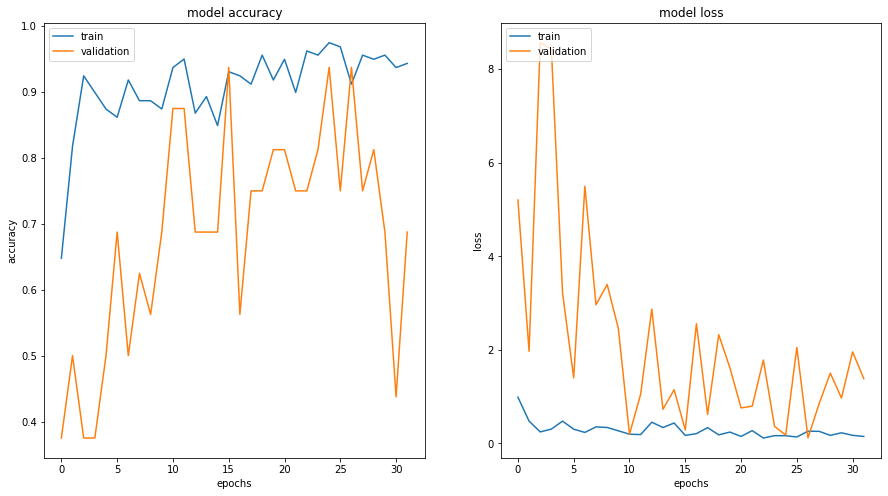

In [16]:
# Performance Visualization
# View Accuracy ( Training, Validation )
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train_loss")
plt.plot(history.history["val_loss"], label="Validate_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')


## 10.3 Model Testing and Performance Visualize

### 10.3.1 Create ImageDataGenerator (Test) and Predict Results

In [17]:
# Initial test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory("./assets/Cat_Dog_Horse/test", class_mode="categorical", target_size=(224,224), color_mode="rgb", shuffle=True, seed=42, batch_size=1)

Found 16 images belonging to 3 classes.


In [18]:
# Get class id for y_real_class
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int32)

In [27]:
# predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
pred_prob = []
for i in range(len(y_true)):
  pred = model.predict(test_generator.next()[0], verbose=0)
  pred_prob.append(pred[0])

In [28]:
pred_prob

[array([0.70357317, 0.25192147, 0.04450535], dtype=float32),
 array([9.9999964e-01, 3.4176503e-07, 5.5272920e-10], dtype=float32),
 array([0.01046132, 0.33902138, 0.6505172 ], dtype=float32),
 array([0.0433318 , 0.915336  , 0.04133211], dtype=float32),
 array([0.91151303, 0.08677939, 0.0017076 ], dtype=float32),
 array([9.999958e-01, 4.011355e-06, 9.337038e-08], dtype=float32),
 array([9.9997473e-01, 2.4954415e-05, 3.1093407e-07], dtype=float32),
 array([9.9999237e-01, 7.4003310e-06, 1.9362137e-07], dtype=float32),
 array([9.9997711e-01, 2.2285856e-05, 6.2711075e-07], dtype=float32),
 array([3.1748888e-01, 6.8222463e-01, 2.8651266e-04], dtype=float32),
 array([3.6945323e-06, 3.1255372e-06, 9.9999321e-01], dtype=float32),
 array([9.9997485e-01, 2.4578247e-05, 5.8098334e-07], dtype=float32),
 array([1.234311e-06, 6.309838e-07, 9.999981e-01], dtype=float32),
 array([0.4689074 , 0.52923703, 0.00185561], dtype=float32),
 array([0.00102761, 0.00128333, 0.9976891 ], dtype=float32),
 array([3.

In [20]:
# Get classID from max prob(pred_prob)
df_pred = pd.DataFrame(pred_prob)
df_class = df_pred.idxmax(axis=1)

In [21]:
df_class

0     0
1     0
2     1
3     2
4     2
5     2
6     0
7     1
8     0
9     2
10    0
11    1
12    0
13    2
14    0
15    0
dtype: int64

In [31]:
confusion_matrix(y_true, df_class)

array([[2, 1, 2],
       [3, 1, 2],
       [3, 1, 1]])

In [29]:
print(classification_report(y_true, df_class, target_names="class"))

              precision    recall  f1-score   support

           0       0.25      0.40      0.31         5
           1       0.33      0.17      0.22         6
           2       0.20      0.20      0.20         5

    accuracy                           0.25        16
   macro avg       0.26      0.26      0.24        16
weighted avg       0.27      0.25      0.24        16

